In [ ]:
!pip install opencv-python
!pip install -q ultralytics==8.3.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 59.4 MB/s eta 0:00:00


In [ ]:
import os
from pathlib import Path
import glob
import math
import json
from typing import List, Dict, Tuple

import cv2
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.optim as optim

from scipy.optimize import linear_sum_assignment

In [ ]:
BASE_DIR = Path("/content/kitti_project")
BASE_DIR.mkdir(parents=True, exist_ok=True)
os.chdir(BASE_DIR)
print("Working dir:", BASE_DIR)


Working dir: /content/kitti_project


In [ ]:
import urllib.request
import zipfile

urls = {
    "image_2": "https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_2.zip",
    "image_3": "https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_3.zip",
    "label_2": "https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_label_2.zip",
}

def download(url, out_path):
    if out_path.exists():
        print(f"[skip] {out_path} exists")
        return
    print(f"Downloading {url} -> {out_path}")
    urllib.request.urlretrieve(url, out_path)
    print("Done.")

for name, url in urls.items():
    zip_path = BASE_DIR / f"{name}.zip"
    download(url, zip_path)

def unzip(zip_path, out_dir):
    if out_dir.exists() and any(out_dir.iterdir()):
        print(f"[skip unzip] {out_dir} not empty")
        return
    print(f"Unzipping {zip_path} -> {out_dir}")
    out_dir.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(out_dir)

unzip(BASE_DIR / "image_2.zip", BASE_DIR / "image_2")
unzip(BASE_DIR / "image_3.zip", BASE_DIR / "image_3")
unzip(BASE_DIR / "label_2.zip", BASE_DIR / "label_2")

LEFT_DIR  = BASE_DIR / "image_2" / "training" / "image_2"
RIGHT_DIR = BASE_DIR / "image_3" / "training" / "image_3"
LABEL_DIR = BASE_DIR / "label_2" / "training" / "label_2"

print("Example left files:", sorted(os.listdir(LEFT_DIR))[:5])
print("Example label files:", sorted(os.listdir(LABEL_DIR))[:5])

Done.
Done.
Done.
Unzipping /content/kitti_project/image_2.zip -> /content/kitti_project/image_2
Unzipping /content/kitti_project/image_3.zip -> /content/kitti_project/image_3
Unzipping /content/kitti_project/label_2.zip -> /content/kitti_project/label_2
Example left files: ['000000.png', '000001.png', '000002.png', '000003.png', '000004.png']
Example label files: ['000000.txt', '000001.txt', '000002.txt', '000003.txt', '000004.txt']


In [ ]:
from ultralytics import YOLO

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Torch device:", DEVICE)

yolo_model = YOLO("yolov8s.pt").to(DEVICE)


Installing YOLOv8...
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Torch device: cpu


100%|██████████| 21.5M/21.5M [00:00<00:00, 188MB/s]


In [ ]:
CONFIG = {
    "fx": 721.5377,
    "fy": 721.5377,
    "cx": 609.5593,
    "cy": 172.8540,
    "baseline": 0.54,
    "device": DEVICE,
    "img_h": 375,
    "img_w": 1242,
}


In [ ]:
def parse_kitti_label_file(label_path: str) -> List[Dict]:
    items = []
    if not os.path.exists(label_path):
        return items
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 15:
                continue
            cls = parts[0]
            if cls == "DontCare":
                continue
            truncated = float(parts[1])
            occluded = int(parts[2])
            alpha = float(parts[3])
            bbox = list(map(float, parts[4:8]))
            h, w, l = map(float, parts[8:11])
            x, y, z = map(float, parts[11:14])
            rotation_y = float(parts[14])
            items.append({
                "type": cls,
                "truncated": truncated,
                "occluded": occluded,
                "alpha": alpha,
                "bbox": bbox,
                "dimensions": [h, w, l],
                "location": [x, y, z],
                "rotation_y": rotation_y
            })
    return items


In [ ]:
def compute_disparity_sgbm(left_img: np.ndarray, right_img: np.ndarray,
                           numDisparities=128, blockSize=7) -> np.ndarray:
    left_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY) if left_img.ndim == 3 else left_img
    right_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY) if right_img.ndim == 3 else right_img
    minDisp = 0
    matcher = cv2.StereoSGBM_create(
        minDisparity=minDisp,
        numDisparities=numDisparities,
        blockSize=blockSize,
        P1=8*3*blockSize**2,
        P2=32*3*blockSize**2,
        disp12MaxDiff=1,
        uniquenessRatio=10,
        speckleWindowSize=100,
        speckleRange=32
    )
    disp = matcher.compute(left_gray, right_gray).astype(np.float32) / 16.0
    disp[disp <= 0] = -1.0
    return disp

def disparity_to_depth(disp: np.ndarray, fx: float, baseline: float) -> np.ndarray:
    z = np.zeros_like(disp, dtype=np.float32)
    mask = disp > 0
    z[mask] = (fx * baseline) / (disp[mask] + 1e-6)
    z[~mask] = 0.0
    return z


In [ ]:
class KittiStereo3DDataset(Dataset):
    def __init__(self, left_dir, right_dir, label_dir, config,
                 transform=None, class_filter="Car", crop_pad=0.1, max_samples=None):
        self.left_dir = Path(left_dir)
        self.right_dir = Path(right_dir)
        self.label_dir = Path(label_dir)
        self.config = config
        self.transform = transform
        self.crop_pad = crop_pad
        self.class_filter = class_filter

        img_names = sorted([os.path.basename(p) for p in glob.glob(str(self.left_dir / "*.png"))])
        self.entries = []
        for img_name in img_names:
            lbl_path = self.label_dir / img_name.replace(".png", ".txt")
            if not lbl_path.exists():
                continue
            items = parse_kitti_label_file(str(lbl_path))
            cars = [it for it in items if it["type"] == class_filter]
            if len(cars) == 0:
                continue
            self.entries.append((img_name, cars))
            if max_samples is not None and len(self.entries) >= max_samples:
                break

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        img_name, objs = self.entries[idx]
        left_path = str(self.left_dir / img_name)
        right_path = str(self.right_dir / img_name)
        left_img = cv2.imread(left_path)
        right_img = cv2.imread(right_path)

        # FIX: Check if images loaded successfully
        if left_img is None or right_img is None:
            raise ValueError(f"Failed to load images: {left_path} or {right_path}")

        left_rgb = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
        right_rgb = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)

        H, W, _ = left_rgb.shape
        samples = []
        for obj in objs:
            x1, y1, x2, y2 = obj["bbox"]
            w = x2 - x1
            h = y2 - y1

            # FIX: Validate bbox dimensions
            if w <= 0 or h <= 0:
                continue

            pad_x = w * self.crop_pad
            pad_y = h * self.crop_pad
            x1p = int(max(0, x1 - pad_x))
            y1p = int(max(0, y1 - pad_y))
            x2p = int(min(W - 1, x2 + pad_x))
            y2p = int(min(H - 1, y2 + pad_y))

            # FIX: Ensure valid crop region
            if x2p <= x1p or y2p <= y1p:
                continue

            left_crop = left_rgb[y1p:y2p, x1p:x2p].copy()
            right_crop = right_rgb[y1p:y2p, x1p:x2p].copy()

            gt_center = np.array(obj["location"], dtype=np.float32)
            dims = np.array(obj["dimensions"], dtype=np.float32)
            yaw = float(obj["rotation_y"])

            samples.append({
                "left_crop": left_crop,
                "right_crop": right_crop,
                "gt_center": gt_center,
                "dims": dims,
                "yaw": yaw,
                "bbox2d": obj["bbox"],
                "img_name": img_name,
            })

        return samples

def collate_flatten(batch):
    flat = []
    for per_image in batch:
        for s in per_image:
            flat.append(s)
    return flat



In [ ]:
class StereoFeatureEncoder(nn.Module):
    def __init__(self, embed_dim=256, pretrained=True, freeze_backbone=True):
        super().__init__()
        if pretrained:
            res = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        else:
            res = models.resnet18(weights=None)
        self.backbone = nn.Sequential(*list(res.children())[:-2])

        # Added convolutional fusion layers
        self.fusion = nn.Sequential(
            nn.Conv2d(512*2, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.pool = nn.AdaptiveAvgPool2d((1,1))
        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, embed_dim)
        )

    def forward(self, left_imgs, right_imgs):
        # Extract features: (B, 512, H, W)
        fl = self.backbone(left_imgs)
        fr = self.backbone(right_imgs)

        # Concatenate spatially
        cat = torch.cat([fl, fr], dim=1)

        # Apply fusion convolutions
        fused = self.fusion(cat)

        # Pool and flatten
        emb = self.pool(fused).flatten(1)
        emb = self.fc(emb)
        return emb

class Regress3DHead(nn.Module):
    def __init__(self, embed_dim=256):
        super().__init__()
        # Output 192 features to be split into 3 chunks of 64
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 192), # 64 * 3 = 192 features
            nn.ReLU()
        )

        # Independent heads for each task taking 64 features each
        self.center = nn.Linear(64, 3)
        self.dims   = nn.Linear(64, 3)
        self.yaw    = nn.Linear(64, 1)

        # Learnable log variances for automatic loss weighting
        # Initialize to 0.0 (variance = 1.0)
        self.loss_log_vars = nn.Parameter(torch.zeros(3))

    def forward(self, emb):
        h = self.mlp(emb) # (B, 192)

        # Split features into 3 equal parts
        h_center, h_dims, h_yaw = torch.split(h, 64, dim=1)

        center = self.center(h_center)
        dims = torch.exp(self.dims(h_dims))
        yaw  = self.yaw(h_yaw).squeeze(1)
        return center, dims, yaw

In [ ]:
def preprocess_crop(img: np.ndarray, out_size=(224,224)):
    # FIX: Handle empty images
    if img.size == 0 or img.shape[0] == 0 or img.shape[1] == 0:
        return np.zeros((3, out_size[0], out_size[1]), dtype=np.float32)

    img = cv2.resize(img, out_size)
    img = img.astype(np.float32) / 255.0
    mean = np.array([0.485,0.456,0.406], dtype=np.float32)
    std  = np.array([0.229,0.224,0.225], dtype=np.float32)
    img = (img - mean) / std
    img = np.transpose(img, (2,0,1))
    return img


In [ ]:
print("\n=== Creating Dataset ===")
dataset_3d = KittiStereo3DDataset(
    LEFT_DIR, RIGHT_DIR, LABEL_DIR, CONFIG,
    crop_pad=0.15, max_samples=300
)
print("3D dataset images with cars:", len(dataset_3d))

loader_3d = DataLoader(dataset_3d, batch_size=4, shuffle=True, collate_fn=collate_flatten)

encoder = StereoFeatureEncoder(embed_dim=256, pretrained=True, freeze_backbone=True).to(DEVICE)
regressor = Regress3DHead(embed_dim=256).to(DEVICE)

# Updated optimizer to include fusion parameters AND loss weights
params_3d = list(regressor.parameters()) + list(encoder.fc.parameters()) + list(encoder.fusion.parameters())
opt_3d = optim.Adam(params_3d, lr=1e-4)

def regression_loss_uncertainty(pred_center, gt_center, pred_dims, gt_dims, pred_yaw, gt_yaw, log_vars):
    # Calculate raw L1 losses
    l_center = nn.functional.l1_loss(pred_center, gt_center)
    l_dims   = nn.functional.l1_loss(pred_dims, gt_dims)
    l_yaw    = nn.functional.l1_loss(pred_yaw, gt_yaw)

    # Multi-task Loss with Homoscedastic Uncertainty
    # Loss = exp(-s) * L + s, where s = log(variance)
    # This effectively weighs the loss by 1/variance

    loss_center = torch.exp(-log_vars[0]) * l_center + log_vars[0]
    loss_dims   = torch.exp(-log_vars[1]) * l_dims   + log_vars[1]
    loss_yaw    = torch.exp(-log_vars[2]) * l_yaw    + log_vars[2]

    total_loss = 3*loss_center + loss_dims + loss_yaw

    return total_loss, (l_center.item(), l_dims.item(), l_yaw.item())

EPOCHS_3D = 10

print("\n=== Training 3D Box Regression (Uncertainty Weighted) ===")
for epoch in range(EPOCHS_3D):
    encoder.train()
    regressor.train()
    total_loss = 0
    ctr_acc = dims_acc = yaw_acc = 0
    n = 0

    for batch in tqdm(loader_3d, desc=f"[3D Box] Epoch {epoch+1}"):
        if len(batch) == 0:
            continue

        left_list, right_list = [], []
        gt_centers, gt_dims, gt_yaws = [], [], []

        for s in batch:
            left_list.append(preprocess_crop(s["left_crop"]))
            right_list.append(preprocess_crop(s["right_crop"]))
            gt_centers.append(s["gt_center"])
            gt_dims.append(s["dims"])
            gt_yaws.append(s["yaw"])

        left_tensor = torch.tensor(np.stack(left_list), dtype=torch.float32, device=DEVICE)
        right_tensor = torch.tensor(np.stack(right_list), dtype=torch.float32, device=DEVICE)
        gt_centers_t = torch.tensor(np.stack(gt_centers), dtype=torch.float32, device=DEVICE)
        gt_dims_t    = torch.tensor(np.stack(gt_dims), dtype=torch.float32, device=DEVICE)
        gt_yaws_t    = torch.tensor(np.stack(gt_yaws), dtype=torch.float32, device=DEVICE)

        opt_3d.zero_grad()
        emb = encoder(left_tensor, right_tensor)
        pred_center, pred_dims, pred_yaw = regressor(emb)

        # Use the learnable weights stored in regressor.loss_log_vars
        loss, (lc, ld, ly) = regression_loss_uncertainty(
            pred_center, gt_centers_t,
            pred_dims, gt_dims_t,
            pred_yaw, gt_yaws_t,
            regressor.loss_log_vars
        )

        loss.backward()
        opt_3d.step()

        total_loss += loss.item()
        ctr_acc += lc
        dims_acc += ld
        yaw_acc  += ly
        n += 1

    # Print current weights to see how they adapt
    weights = torch.exp(-regressor.loss_log_vars).detach().cpu().numpy()
    print(f"Epoch {epoch+1}: loss={total_loss/n:.4f}, ctr={ctr_acc/n:.3f}, dims={dims_acc/n:.3f}, yaw={yaw_acc/n:.3f}")
    print(f"   -> Learned Weights: Ctr={weights[0]:.2f}, Dims={weights[1]:.2f}, Yaw={weights[2]:.2f}")


=== Creating Dataset ===
3D dataset images with cars: 300

=== Training 3D Box Regression (Uncertainty Weighted) ===


[3D Box] Epoch 1: 100%|██████████| 75/75 [00:23<00:00,  3.23it/s]


Epoch 1: loss=35.6091, ctr=11.128, dims=0.793, yaw=1.532
   -> Learned Weights: Ctr=0.99, Dims=1.00, Yaw=0.99


[3D Box] Epoch 2: 100%|██████████| 75/75 [00:23<00:00,  3.25it/s]


Epoch 2: loss=15.2431, ctr=4.398, dims=0.601, yaw=1.543
   -> Learned Weights: Ctr=0.99, Dims=1.01, Yaw=0.99


[3D Box] Epoch 3: 100%|██████████| 75/75 [00:23<00:00,  3.24it/s]


Epoch 3: loss=14.1743, ctr=4.119, dims=0.447, yaw=1.495
   -> Learned Weights: Ctr=0.99, Dims=1.02, Yaw=0.98


[3D Box] Epoch 4: 100%|██████████| 75/75 [00:23<00:00,  3.26it/s]


Epoch 4: loss=13.7994, ctr=4.047, dims=0.342, yaw=1.479
   -> Learned Weights: Ctr=0.98, Dims=1.03, Yaw=0.97


[3D Box] Epoch 5: 100%|██████████| 75/75 [00:23<00:00,  3.24it/s]


Epoch 5: loss=12.8065, ctr=3.812, dims=0.298, yaw=1.260
   -> Learned Weights: Ctr=0.98, Dims=1.04, Yaw=0.97


[3D Box] Epoch 6: 100%|██████████| 75/75 [00:23<00:00,  3.24it/s]


Epoch 6: loss=12.6283, ctr=3.826, dims=0.274, yaw=1.099
   -> Learned Weights: Ctr=0.98, Dims=1.05, Yaw=0.97


[3D Box] Epoch 7: 100%|██████████| 75/75 [00:23<00:00,  3.22it/s]


Epoch 7: loss=11.7848, ctr=3.570, dims=0.256, yaw=1.061
   -> Learned Weights: Ctr=0.97, Dims=1.06, Yaw=0.97


[3D Box] Epoch 8: 100%|██████████| 75/75 [00:23<00:00,  3.25it/s]


Epoch 8: loss=11.6464, ctr=3.537, dims=0.238, yaw=1.073
   -> Learned Weights: Ctr=0.97, Dims=1.07, Yaw=0.97


[3D Box] Epoch 9: 100%|██████████| 75/75 [00:23<00:00,  3.26it/s]


Epoch 9: loss=10.8693, ctr=3.281, dims=0.250, yaw=1.060
   -> Learned Weights: Ctr=0.96, Dims=1.07, Yaw=0.97


[3D Box] Epoch 10: 100%|██████████| 75/75 [00:22<00:00,  3.28it/s]

Epoch 10: loss=10.0405, ctr=3.010, dims=0.221, yaw=1.075
   -> Learned Weights: Ctr=0.96, Dims=1.08, Yaw=0.97


In [ ]:
def run_yolo_image(img_path: str, model, device=DEVICE, car_class_id=2):
    res = model.predict(source=img_path, imgsz=640, conf=0.25, verbose=False, device=device)[0]
    boxes = res.boxes
    xyxy = boxes.xyxy.cpu().numpy() if boxes is not None else np.zeros((0,4))
    conf = boxes.conf.cpu().numpy() if boxes is not None else np.zeros((0,))
    cls  = boxes.cls.cpu().numpy() if boxes is not None else np.zeros((0,))
    mask = (cls == car_class_id)
    return xyxy[mask], conf[mask]

def infer_3d_from_detection(left_img_rgb, right_img_rgb, detection_bbox, encoder, regressor, device=DEVICE, pad=0.15):
    H, W, _ = left_img_rgb.shape
    x1, y1, x2, y2 = detection_bbox
    w = x2 - x1
    h = y2 - y1

    # FIX: Validate detection bbox
    if w <= 0 or h <= 0:
        return None, None, None, None

    x1p = int(max(0, x1 - pad*w))
    y1p = int(max(0, y1 - pad*h))
    x2p = int(min(W-1, x2 + pad*w))
    y2p = int(min(H-1, y2 + pad*h))

    # FIX: Validate crop region
    if x2p <= x1p or y2p <= y1p:
        return None, None, None, None

    left_crop = left_img_rgb[y1p:y2p, x1p:x2p]
    right_crop = right_img_rgb[y1p:y2p, x1p:x2p]

    left_t = torch.tensor(preprocess_crop(left_crop), dtype=torch.float32, device=device).unsqueeze(0)
    right_t = torch.tensor(preprocess_crop(right_crop), dtype=torch.float32, device=device).unsqueeze(0)

    with torch.no_grad():
        encoder.eval()
        regressor.eval()
        emb = encoder(left_t, right_t)
        pred_center, pred_dims, pred_yaw = regressor(emb)

    return (emb.squeeze(0).cpu().numpy(),
            pred_center.cpu().numpy()[0],
            pred_dims.cpu().numpy()[0],
            float(pred_yaw.cpu().numpy()[0]))



In [ ]:
print("\n=== Testing Inference Pipeline ===")
sample_img_name = sorted(os.listdir(LEFT_DIR))[14]
sample_left_path = str(LEFT_DIR / sample_img_name)
sample_right_path = str(RIGHT_DIR / sample_img_name)
print("Sample image:", sample_img_name)

left_img_bgr = cv2.imread(sample_left_path)
right_img_bgr = cv2.imread(sample_right_path)
left_img_rgb  = cv2.cvtColor(left_img_bgr, cv2.COLOR_BGR2RGB)
right_img_rgb = cv2.cvtColor(right_img_bgr, cv2.COLOR_BGR2RGB)

bboxes, confs = run_yolo_image(sample_left_path, yolo_model)
print("YOLO car detections:", len(bboxes))

if len(bboxes) > 0:
    result = infer_3d_from_detection(left_img_rgb, right_img_rgb, bboxes[0], encoder, regressor, DEVICE)
    if result[1] is not None:
        emb0, center0, dims0, yaw0 = result
        print("Pred 3D center:", center0)
        print("Pred dims:", dims0)
        print("Pred yaw:", yaw0)
        print()
    else:
        print("Invalid detection bbox")

print("\n=== Pipeline Complete ===")
print("3D box regression model trained successfully!")
print("Next steps: Add motion tracking, Kalman filtering, visualization")


=== Testing Inference Pipeline ===
Sample image: 000014.png
YOLO car detections: 1
Pred 3D center: [    -1.3052       1.016      71.628]
Pred dims: [     1.6872      1.7878      4.7586]
Pred yaw: -0.3907616138458252


=== Pipeline Complete ===
3D box regression model trained successfully!
Next steps: Add motion tracking, Kalman filtering, visualization


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import copy

# ---------- Helper: draw 2D YOLO detections ----------
def visualize_2d_detections(img_rgb, bboxes, confs=None, title="YOLO 2D Detections"):
    img_vis = img_rgb.copy()
    for i, box in enumerate(bboxes):
        x1, y1, x2, y2 = box.astype(int)
        cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
        label = f"{confs[i]:.2f}" if confs is not None and len(confs) > i else ""
        if label:
            cv2.putText(img_vis, label, (x1, max(0, y1 - 5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)

    plt.figure(figsize=(12, 6))
    plt.imshow(img_vis)
    plt.axis("off")
    plt.title(title)
    plt.show()

# ---------- Helpers: 3D box math ----------
def get_3d_box_corners(dimensions, location, yaw):
    """
    dimensions: [h, w, l]
    location: [x, y, z] in camera coordinates
    yaw: rotation around Y axis (KITTI's ry)
    Returns: (8, 3) array of 3D corners in camera frame
    """
    h, w, l = dimensions
    x, y, z = location

    # Box in its local coordinates (camera frame, y-down, z-forward)
    # Center at (0,0,0) first
    x_corners = np.array([ w/2,  w/2, -w/2, -w/2,  w/2,  w/2, -w/2, -w/2])
    y_corners = np.array([   0,    0,    0,    0,  -h,  -h,  -h,  -h])
    z_corners = np.array([ l/2, -l/2, -l/2,  l/2,  l/2, -l/2, -l/2,  l/2])

    # Rotation around Y axis
    c = math.cos(yaw)
    s = math.sin(yaw)
    R = np.array([[ c, 0,  s],
                  [ 0, 1,  0],
                  [-s, 0,  c]])

    corners_3d = np.vstack((x_corners, y_corners, z_corners))
    corners_3d = R @ corners_3d

    # Translate to location
    corners_3d[0, :] += x
    corners_3d[1, :] += y
    corners_3d[2, :] += z
    return corners_3d.T  # (8,3)

def project_to_image(pts_3d, K):
    """
    pts_3d: (N,3) camera coordinates
    K: (3,3) intrinsics
    Returns: (N,2) pixel coordinates
    """
    pts_3d = pts_3d.T  # (3, N)
    proj = K @ pts_3d
    proj[:2, :] /= proj[2, :] + 1e-6
    return proj[:2, :].T  # (N, 2)

def draw_projected_3d_box(img_rgb, center, dims, yaw, K, color=(255, 0, 0), thickness=2):
    """
    Draw a single predicted 3D box projected into the image.
    """
    img_vis = img_rgb.copy()
    corners_3d = get_3d_box_corners(dims, center, yaw)  # (8,3)
    pts_2d = project_to_image(corners_3d, K).astype(int)

    # KITTI convention edges
    # 0-3 bottom face, 4-7 top face
    edges = [
        (0, 1), (1, 2), (2, 3), (3, 0),   # bottom
        (4, 5), (5, 6), (6, 7), (7, 4),   # top
        (0, 4), (1, 5), (2, 6), (3, 7)    # sides
    ]

    for i1, i2 in edges:
        p1 = tuple(pts_2d[i1])
        p2 = tuple(pts_2d[i2])
        cv2.line(img_vis, p1, p2, color, thickness)

    return img_vis

# ---------- Helper: simple top-down BEV for multiple boxes ----------
def visualize_bev_boxes(centers, dims, yaws, title="Top-Down (BEV) View"):
    """
    centers: list of [x,y,z]
    dims: list of [h,w,l]
    yaws: list of yaw
    We'll plot x (left/right) vs z (forward) ignoring y (height).
    """
    plt.figure(figsize=(6, 8))
    ax = plt.gca()
    ax.set_aspect('equal', 'box')

    for c, d, ry in zip(centers, dims, yaws):
        h, w, l = d
        x, y, z = c

        # 2D rectangle corners in local box frame (x-z plane)
        # (use same as 3D but drop y)
        x_corners = np.array([ w/2,  w/2, -w/2, -w/2])
        z_corners = np.array([ l/2, -l/2, -l/2,  l/2])

        c_yaw = math.cos(ry)
        s_yaw = math.sin(ry)
        R = np.array([[ c_yaw,  s_yaw],
                      [-s_yaw,  c_yaw]])  # rotate in x-z plane (z forward)

        corners = np.vstack((x_corners, z_corners))
        corners = R @ corners
        corners[0, :] += x
        corners[1, :] += z

        # Plot polygon
        poly = plt.Polygon(corners.T, fill=False)
        ax.add_patch(poly)
        # Draw center
        ax.plot(x, z, 'o')

    plt.grid(True)
    plt.xlabel("X (left/right)")
    plt.ylabel("Z (forward)")
    plt.title(title)
    plt.gca().invert_xaxis()  # so that left is to the left visually
    plt.show()



=== Visualization on sample image ===
Sample image: 000014.png


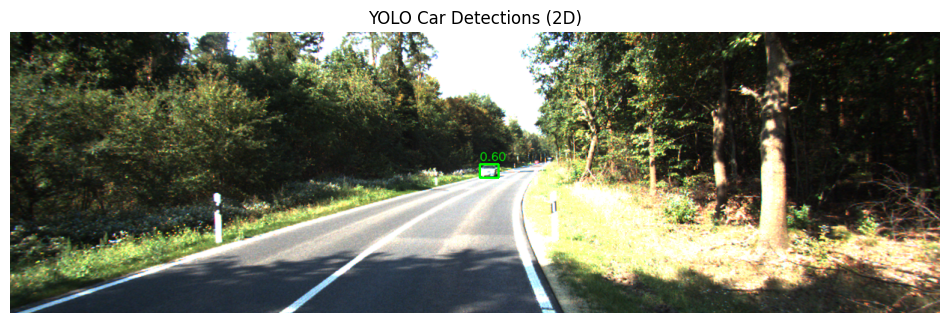

Predicted 3D boxes: 1


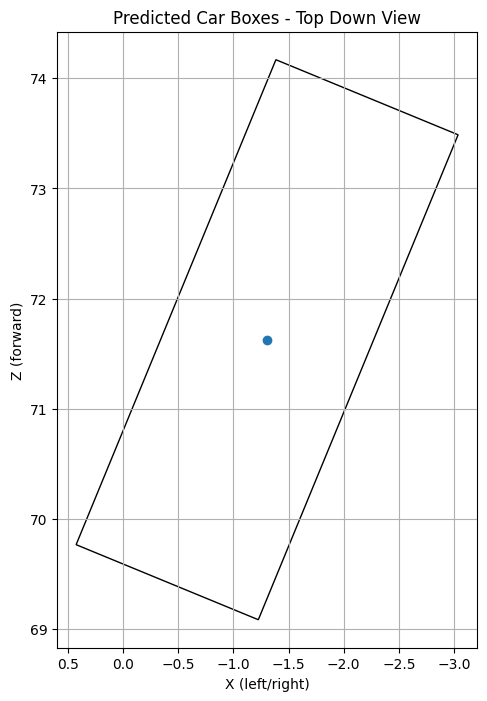

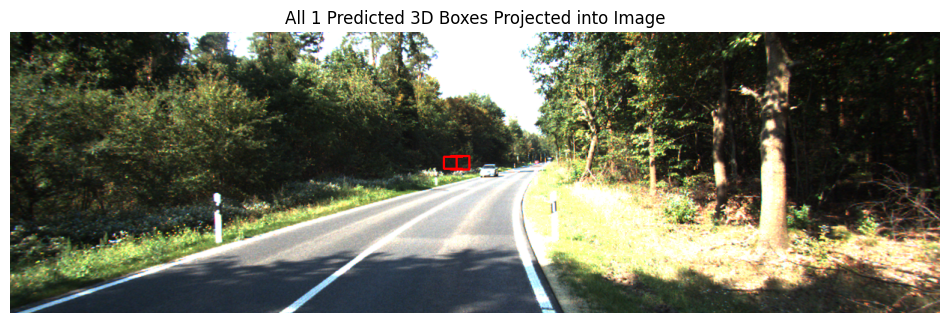

In [ ]:
print("\n=== Visualization on sample image ===")
print("Sample image:", sample_img_name)

# 1) Show 2D detections
if len(bboxes) > 0:
    visualize_2d_detections(left_img_rgb, bboxes, confs, title="YOLO Car Detections (2D)")

# 2) For each detection, run 3D inference and collect boxes
pred_centers = []
pred_dims_list = []
pred_yaws = []

for box in bboxes:
    result = infer_3d_from_detection(left_img_rgb, right_img_rgb, box, encoder, regressor, DEVICE)
    if result[1] is None:
        continue
    emb0, center0, dims0, yaw0 = result
    pred_centers.append(center0)
    pred_dims_list.append(dims0)
    pred_yaws.append(yaw0)

print(f"Predicted 3D boxes: {len(pred_centers)}")

# 3) Visualize BEV 3D boxes
if len(pred_centers) > 0:
    visualize_bev_boxes(pred_centers, pred_dims_list, pred_yaws,
                        title="Predicted Car Boxes - Top Down View")

# 4) Project and draw ALL predicted 3D boxes into the image
if len(pred_centers) > 0:
    fx = CONFIG["fx"]
    fy = CONFIG["fy"]
    cx = CONFIG["cx"]
    cy = CONFIG["cy"]
    K = np.array([[fx, 0,  cx],
                  [0,  fy, cy],
                  [0,  0,   1]], dtype=np.float32)

    img_3d = left_img_rgb.copy()
    for i in range(len(pred_centers)):
        img_3d = draw_projected_3d_box(img_3d, pred_centers[i], pred_dims_list[i], pred_yaws[i], K,
                                       color=(255, 0, 0), thickness=2)

    plt.figure(figsize=(12, 6))
    plt.imshow(img_3d)
    plt.axis("off")
    plt.title(f"All {len(pred_centers)} Predicted 3D Boxes Projected into Image")
    plt.show()
else:
    print("No valid 3D box predictions to visualize.")


=== Ground Truth Visualization ===
Loading labels from: /content/kitti_project/label_2/training/label_2/000014.txt
Found 1 ground truth cars.


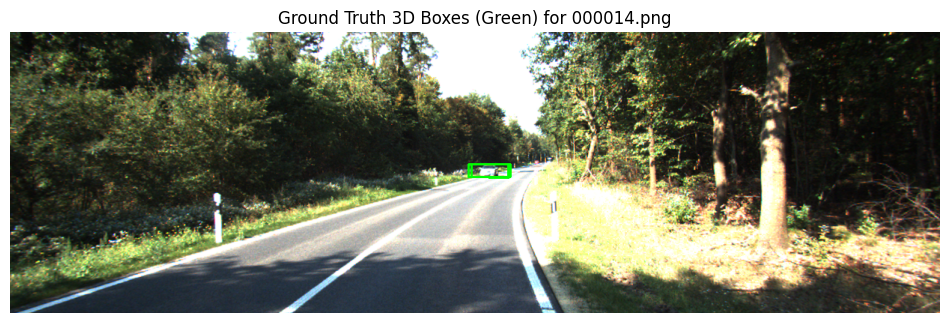

In [ ]:
print("\n=== Ground Truth Visualization ===")
# Get label path for the sample image
label_path = LABEL_DIR / sample_img_name.replace(".png", ".txt")
print(f"Loading labels from: {label_path}")

# Parse ground truth items
gt_items = parse_kitti_label_file(str(label_path))

# Filter for Cars/Vans just like we did for training
gt_cars = [item for item in gt_items if item["type"] in ["Car", "Van"]]
print(f"Found {len(gt_cars)} ground truth cars.")

# Prepare image for drawing
img_gt_vis = left_img_rgb.copy()

# Camera intrinsics (same as used before)
K = np.array([[CONFIG["fx"], 0,  CONFIG["cx"]],
              [0,  CONFIG["fy"], CONFIG["cy"]],
              [0,  0,   1]], dtype=np.float32)

# Draw each ground truth box
for item in gt_cars:
    # Extract 3D properties
    # KITTI dimensions: height, width, length
    dims = np.array(item["dimensions"], dtype=np.float32)
    # KITTI location: x, y, z (camera coords)
    loc  = np.array(item["location"], dtype=np.float32)
    rot_y = float(item["rotation_y"])

    # Draw in Green (0, 255, 0)
    img_gt_vis = draw_projected_3d_box(img_gt_vis, loc, dims, rot_y, K, color=(0, 255, 0), thickness=2)

plt.figure(figsize=(12, 6))
plt.imshow(img_gt_vis)
plt.axis("off")
plt.title(f"Ground Truth 3D Boxes (Green) for {sample_img_name}")
plt.show()